In [13]:
import matplotlib.pyplot as plt
import numpy as np

def imageplot(f, str='', sbpt=[]):
    """
        Use nearest neighbor interpolation for the display.
    """
    if sbpt != []:
        plt.subplot(sbpt[0], sbpt[1], sbpt[2])
    imgplot = plt.imshow(f, interpolation='nearest')
    imgplot.set_cmap('gray')
    plt.axis('off')
    if str != '':
        plt.title(str)


def dijstra(x0,W,bound = 'per'):
    n = W.shape[0]
    
    neigh = np.array([[1, -1, 0, 0], [0, 0,  1, -1]])
    def symmetrize(x,n):
        if (x<0):
            x = -x;
        elif (x>=n):
            x = 2*(n-1)-x
        return x


    if bound=='per':
        boundary = lambda x: np.mod(x,n)
    else:
        boundary = lambda x: [symmetrize(x[0],n), symmetrize(x[1],n)]
    #boundary = lambda x: x*np.logical_and(x<=n,x>0) + (2-x) * (x<=0) + (2*n-x)*(x>n)
    #boundary = lambda x: np.mod(x,n)
    ind2sub1 = lambda k: [int( (k-np.fmod(k,n))/n ), np.fmod(k,n)]
    sub2ind1 = lambda u: int( u[0]*n + u[1] )
    Neigh = lambda k,i: sub2ind1(boundary(ind2sub1(k) + neigh[:,i]))
    
    I = [sub2ind1(x0)]
    D = np.ones( (n,n) ) + np.inf
    u = ind2sub1(I)
    D[u[0],u[1]] = 0
    S = np.zeros( (n,n) )
    S[u[0],u[1]] = 1
    extract   = lambda x,I: x[I]
    extract1d = lambda x,I: extract(x.flatten(),I)
    num = 0
    while I is not []:
        j = np.argsort( extract1d(D,I)  )
        if j is []:
            break
        if np.ndim(j)==0:
            j = [j]   # make sure that j is a list a not a singleton
        #print(j)
        j = j[0]
        i = I[j]         
        a = I.pop(j)
        u = ind2sub1(i);
        S[u[0],u[1]] = -1
        J = [] 
        for k in np.arange(0,4):
            j = Neigh(i,k)
            if extract1d(S,j)!=-1:
                # add to the list of point to update
                J.append(j)           
                if extract1d(S,j)==0:
                    # add to the front
                    u = ind2sub1(j)
                    S[u[0],u[1]] = 1
                    I.append(j)
        DNeigh = lambda D,k: extract1d(D,Neigh(j,k))
        for j in J:
            dx = min(DNeigh(D,0), DNeigh(D,1))
            dy = min(DNeigh(D,2), DNeigh(D,3))
            u = ind2sub1(j)
            w = extract1d(W,j);
            #D[u[0],u[1]] = min(dx + w, dy + w)
            Delta = 2*w - (dx-dy)**2
            if (Delta>=0):
                D[u[0],u[1]] = (dx + dy + np.sqrt(Delta))/ 2
            else:
                D[u[0],u[1]] = min(dx + w, dy + w)
        if num % 5000 == 0:
            displ = lambda D: np.cos(2*np.pi*5*D/max(D.flatten()) )
            imageplot(D)
            plt.set_cmap('jet')
            plt.show()
            #print(I)
        
        num += 1
    
    return D

def exo1(x0,W,bound):

    """
        Implement the Dijkstra algorithm by iterating these step while the
        stack |I| is non empty.
        Display from time to time the front that propagates.
    """
    n = W.shape[0]
    pstart = np.transpose(np.array([x0]))
    D = dijstra(pstart,W,bound)
    #[D,Dsvg,Ssvg] = perform_dijstra_fm(W, pstart, inf,'dijstr', 'sym',n*6)
    
    return D

(246, 246)


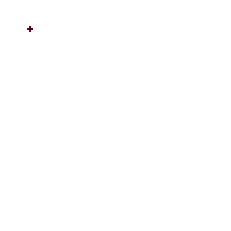

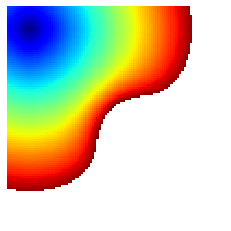

IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
from imageio import imread
img = imread('../data/vessels.png')
print(img.shape)
#D,S = fast_marching_2D(img, [142,226])
#D = exo1([142,226],img,'sym')
W = np.ones( (30,30) )
n = 100
x = np.linspace(-1, 1, n)
[Y, X] = np.meshgrid(x, x)
sigma = .2
W = 1 + 8 * np.exp(-(X**2 + Y**2)/ (2*sigma**2))

x0 = [30/2,30/2]
x0 = [np.round(.1*n), np.round(.1*n)]
D = exo1(x0,W,'sym')

In [27]:
import numpy as np
import pylab
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import ndimage
# graph.py: TODO: try to not make use of transform.resize
# from skimage import transform ### commented

def plot(img,propa):
    plt.imshow(img,cmap='gray')
    plt.imshow(propa)
    plt.show()

def perform_dijstra_fm(W, pstart, niter=np.inf, method='dijstr', bound='sym', svg_rate=1000000):
    """
    % perform_fm_dijstra - *slow* (matlab) implementation of Dijstra and FM
    %
    %   [D,Dsvg,Ssvg] = perform_fm_dijstra(W, pstart, options);
    %
    %   W is an (n,n) metric matrix.
    %   pstart is a (2,k) starting points.
    %   options.method is either 'fm' or 'dijstra'
    %
    %   D is the final distance map to pstart
    %   options.svg_rate gives the rate at wich Dsvg and Ssvg is filled.
    %   options.niter can be used to limit the total number of steps (partial propagation).
    %
    %   Copyright (c) 2014 Gabriel Peyre
    """
    ##
    # Size.

    n = W.shape[0]

    ##
    # The four displacement vector to go to the four neightbors.

    neigh = np.array([[1, -1, 0, 0], [0, 0,  1, -1]])

    ##
    # For simplicity of implementation, we use periodic boundary conditions.

    # boundary = @(x)x.*(x<=n & x>0) + (2-x).*(x<=0) + (2*n-x).*(x>n);
    def symmetrize(x,n):
        if (x<0):
            x = -x;
        elif (x>=n):
            x = 2*(n-1)-x
        return x


    if bound=='per':
        boundary = lambda x: np.mod(x,n)
    else:
        boundary = lambda x: [symmetrize(x[0],n), symmetrize(x[1],n)] # todo

    ##
    # For a given grid index |k|, and a given neighboring index k in \({1,2,3,4}\),
    # |Neigh(k,i)| gives the corresponding grid neigboring index.

    ind2sub1 = lambda k: [int( (k-np.fmod(k,n))/n ), np.fmod(k,n)]
    sub2ind1 = lambda u: int( u[0]*n + u[1] )
    Neigh = lambda k,i: sub2ind1(boundary(ind2sub1(k) + neigh[:,i]))
    extract   = lambda x,I: x[I]
    extract1d = lambda x,I: extract(x.flatten(),I)

    ##
    # Stack of starting points.

    nstart = pstart.shape[1]
    I = list( np.zeros( (nstart, 1) ) )
    for i in np.arange(0, nstart):
        I[i] = int( sub2ind1(pstart[:,i]) )

    ##
    # Initialize the distance to \(+\infty\), excepted for the boundary conditions.

    D = np.zeros( (n,n) ) + np.inf # current distance
    for i in np.arange(0, nstart):
        D[int(pstart[0,i]),int(pstart[1,i])] = 0


    ##
    # Initialize the state to 0 (unexplored), excepted for the boundary point to \(1\)
    # (front).

    S = np.zeros( (n,n) )
    for i in np.arange(0, nstart):
        S[int(pstart[0,i]),int(pstart[1,i])] = 1 # open

    ##
    # Run!

    iter = 0
    q = 100  # maximum number of saves
    Dsvg = np.zeros( (n,n,q) )
    Ssvg = np.zeros( (n,n,q) )
    while ( not(I==[]) & (iter<=niter) ):
        # print(not(I==[]) & (iter<=niter))
        iter = iter+1;
        # print(len(I))
        if iter==niter:
            break
        # pop from stack
        j = np.argsort( extract1d(D,I)  )
        if np.ndim(j)==0:
            j = [j]
        j = j[0]
        i = I[j]
        a = I.pop(j)
        # declare dead
        u = ind2sub1(i);
        S[u[0],u[1]] = -1
        # Make a list of neighbors that are not dead
        J = []
        for k in np.arange(0,4):
            j = Neigh(i,k)
            if extract1d(S,j)!=-1:
                # add to the list of point to update
                J.append(j)
                if extract1d(S,j)==0:
                    # add to the front
                    u = ind2sub1(j)
                    S[u[0],u[1]] = 1
                    I.append(j)
        # update neighbor values
        DNeigh = lambda D,k: extract1d(D,Neigh(j,k))
        for j in J:
            dx = min(DNeigh(D,0), DNeigh(D,1))
            dy = min(DNeigh(D,2), DNeigh(D,3))
            u = ind2sub1(j)
            w = extract1d(W,j);
            if method=='dijstr':
                D[u[0],u[1]] = min(dx + w, dy + w)
            else:
                Delta = 2*w - (dx-dy)**2
                if (Delta>=0):
                    D[u[0],u[1]] = (dx + dy + np.sqrt(Delta))/ 2
                else:
                    D[u[0],u[1]] = min(dx + w, dy + w)
        # svd
        t = int(iter/svg_rate)
        if (np.mod(iter,svg_rate)==0) & (t<q):
            Dsvg[:,:,t-1] = D
            Ssvg[:,:,t-1] = S
        
        if iter % 5000 == 0:
            plot(W,D)

    Dsvg = Dsvg[:,:,:t-1]
    Ssvg = Ssvg[:,:,:t-1]
    return (D,Dsvg,Ssvg);

def exo3(x0,W):
    """
    Compute the distance map to these starting point using the FM algorithm.
    """
    n = W.shape[0]
    pstart = np.transpose(np.array([x0]))
    [D,Dsvg,Ssvg] = perform_dijstra_fm(W, pstart, np.inf,'fm', 'sym',n*6)
    # display
    k = 8
    displ = lambda D: np.cos(2*np.pi*k*D/ max(D.flatten()))
    plt.clf
    imageplot(D)
    plt.set_cmap('jet')
    return D

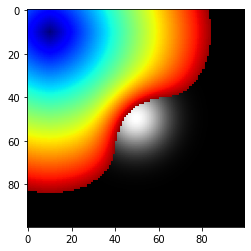

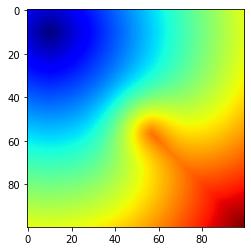

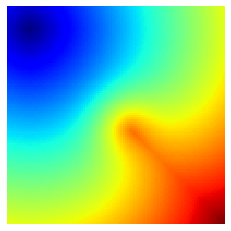

In [4]:
n = 100
x = np.linspace(-1, 1, n)
[Y, X] = np.meshgrid(x, x)
sigma = .2
W = 1 + 8 * np.exp(-(X**2 + Y**2)/ (2*sigma**2))


x0 = [np.round(.1*n), np.round(.1*n)]
D = exo3(x0,W)

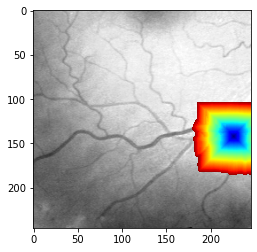

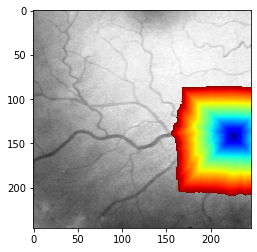

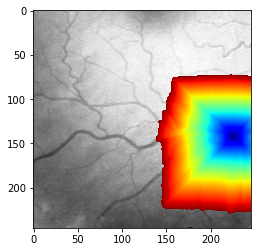

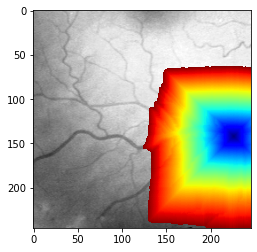

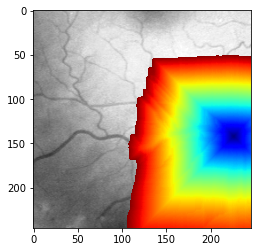

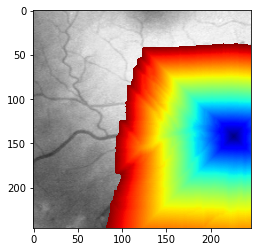

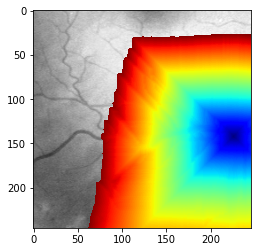

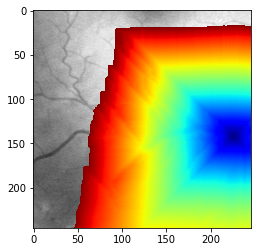

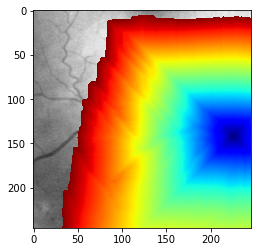

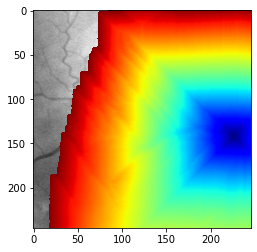

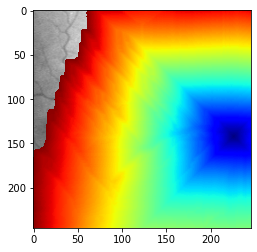

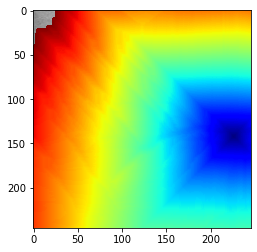

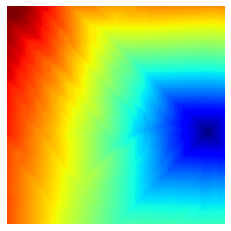

In [5]:
D = exo3([142,226],img)

In [5]:
def perform_blurring(f, sigma):

    """ gaussian_blur - gaussian blurs an image
    %
    %   M = perform_blurring(M, sigma, options);
    %
    %   M is the original data
    %   sigma is the std of the Gaussian blur (in pixels)
    %
    %   Copyright (c) 2007 Gabriel Peyre
    """
    if sigma<=0:
        return;
    n = max(f.shape);
    t = np.concatenate( (np.arange(0,n/2+1), np.arange(-n/2,-1)) )
    [Y,X] = np.meshgrid(t,t)
    h = np.exp( -(X**2+Y**2)/(2.0*float(sigma)**2) )
    h = h/np.sum(h)
    return np.real( pylab.ifft2(pylab.fft2(f) * pylab.fft2(h)) )


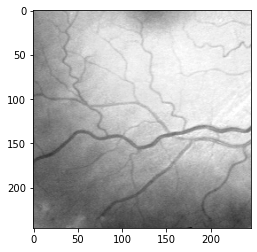

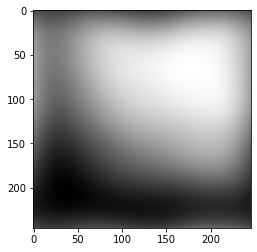

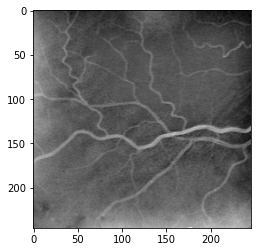

In [6]:
plt.imshow(img,cmap='gray')
plt.show()
M = perform_blurring(img,20)
plt.imshow(M,cmap='gray')
plt.show()
plt.imshow(M-img,cmap='gray')

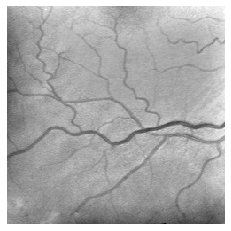

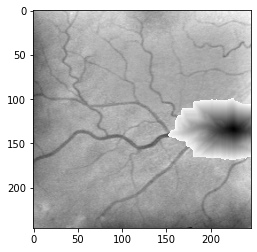

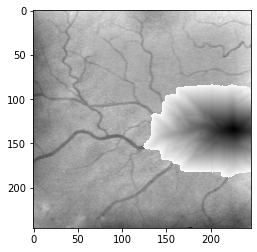

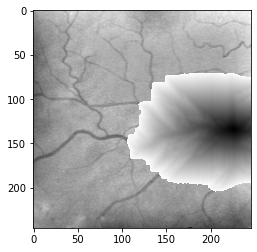

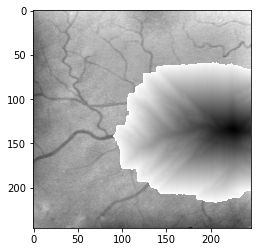

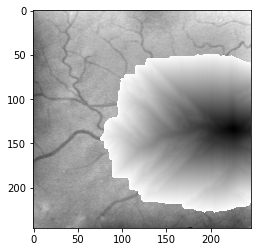

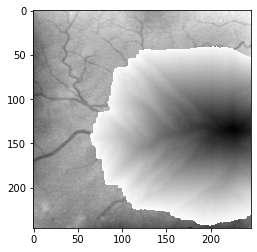

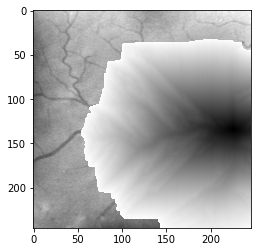

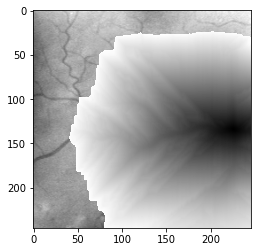

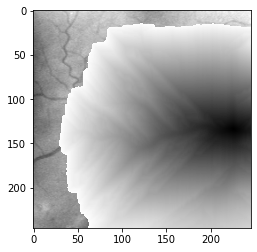

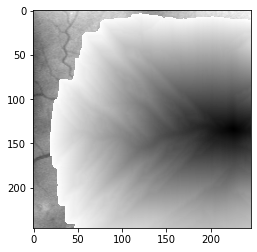

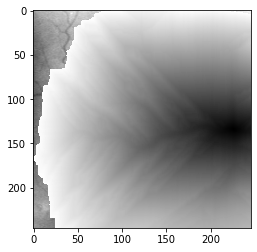

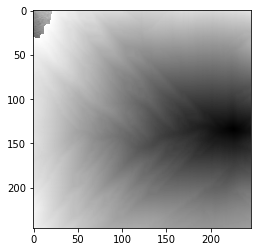

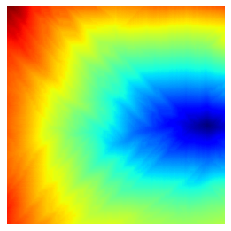

In [134]:
img2 = M - img
c = np.max(img2);
epsilon = 1e-2;
W = epsilon + np.abs(img2-c);
imageplot(W)
plt.show()
# Get brightness range - i.e. darkest and lightest pixels

D = exo3([134,226],W)

In [135]:
def grad(f):
    """
        Compute a finite difference approximation of the gradient of a 2D image, assuming periodic BC.
    """
    S = f.shape;
#   g = np.zeros([n[0], n[1], 2]);
    s0 = np.concatenate( (np.arange(1,S[0]),[0]) )
    s1 = np.concatenate( (np.arange(1,S[1]),[0]) )
    g = np.dstack( (f[s0,:] - f, f[:,s1] - f))
    return g

def bilinear_interpolate(im, x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, im.shape[1]-1);
    x1 = np.clip(x1, 0, im.shape[1]-1);
    y0 = np.clip(y0, 0, im.shape[0]-1);
    y1 = np.clip(y1, 0, im.shape[0]-1);

    Ia = im[ y0, x0 ]
    Ib = im[ y1, x0 ]
    Ic = im[ y0, x1 ]
    Id = im[ y1, x1 ]

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    return wa*Ia + wb*Ib + wc*Ic + wd*Id

def exo4(tau,x0,x1,G):
    """
    Perform the full geodesic path extraction by iterating the gradient
    descent. You must be very careful when the path become close to
    $x_0$, because the distance function is not differentiable at this
    point. You must stop the iteration when the path is close to $x_0$.
    """
    n = G.shape[0]
    Geval = lambda G,x: bilinear_interpolate(G[:,:,0], np.imag(x), np.real(x) ) + 1j * bilinear_interpolate(G[:,:,1],np.imag(x), np.real(x))
    niter = 1.5*n/tau;
    # init gamma
    gamma = [x1]
    xtgt = x0[0] + 1j*x0[1]
    for i in np.arange(0,niter):
        g = Geval(G, gamma[-1] )
        gamma.append( gamma[-1] - tau*g )
        if np.abs(gamma[-1]-xtgt).all()<1:
            break
    gamma.append( xtgt )
    return gamma


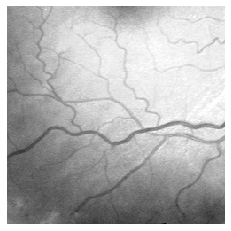

In [136]:
G0 = grad(D)
n = G0.shape[0]
d = np.sqrt(np.sum(G0**2, axis=2))
U = np.zeros((n,n,2))
U[:,:,0] = d
U[:,:,1] = d
G = G0 / U
gamma = exo4(.8,[134,226],166 + 1j*9,G)
imageplot(img) 
plt.set_cmap('gray')

#h = plt.plot(np.imag(gamma), np.real(gamma), '.b', linewidth=2)
#h = plt.plot(x0[1], x0[0], '.r', markersize=20)
#h = plt.plot(np.imag(x1), np.real(x1), '.g', markersize=20)

In [97]:
tempGamma = np.delete(gamma,0)

/Users/nicolasmakaroff/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [98]:
newGamma = np.delete(tempGamma,-1)

In [99]:
finGamma = np.concatenate(newGamma)

[134, 226]


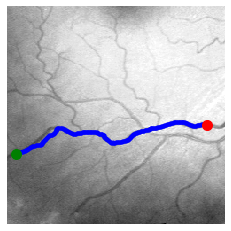

In [137]:
G0 = grad(D)
n = G0.shape[0]
d = np.sqrt(np.sum(G0**2, axis=2))
U = np.zeros((n,n,2))
U[:,:,0] = d
U[:,:,1] = d
G = G0 / U
#gamma = exo4(.8,[142,226],[9,174],G)
imageplot(img) 
plt.set_cmap('gray')
#x1 = [166,9]
x1 = 166 + 1j*9
x0 = [134,226]
print(x0)
h = plt.plot(np.imag(gamma), np.real(gamma), '.b', linewidth=2)
h = plt.plot(x0[1], x0[0], '.r', markersize=20)
h = plt.plot(np.imag(x1), np.real(x1), '.g', markersize=20)

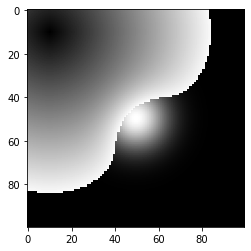

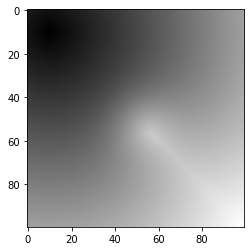

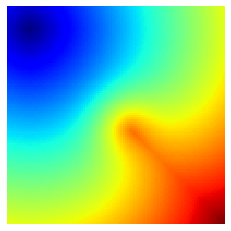

In [108]:
n = 100
x = np.linspace(-1, 1, n)
[Y, X] = np.meshgrid(x, x)
sigma = .2
W = 1 + 8 * np.exp(-(X**2 + Y**2)/ (2*sigma**2))


x0 = [np.round(.1*n), np.round(.1*n)]
D = exo3(x0,W)
G0 = grad(D)
d = np.sqrt(np.sum(G0**2, axis=2))
U = np.zeros((n,n,2))
U[:,:,0] = d
U[:,:,1] = d
G = G0 / U

tau = .8
x1 = round(.9*n) + 1j*round(.88*n)
gamma = [x1]
Geval = lambda G,x: bilinear_interpolate(G[:,:,0], np.imag(x), np.real(x) ) + 1j * bilinear_interpolate(G[:,:,1],np.imag(x), np.real(x))
g = Geval(G, gamma[-1] )
gamma.append( gamma[-1] - tau*g )


[10.0, 10.0]


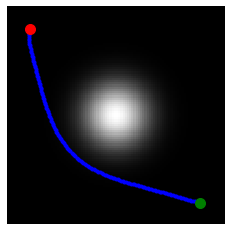

In [126]:

x1 = round(.9*n) + 1j*round(.88*n)
gamma = exo4(.8,x0,x1,G)
imageplot(W) 
plt.set_cmap('gray')
print(x0)
h = plt.plot(np.imag(gamma), np.real(gamma), '.b', linewidth=2)
h = plt.plot(x0[1], x0[0], '.r', markersize=20)
#h = plt.plot(np.imag(x1), np.real(x1), '.g', markersize=20)
plt.plot(88,90, '.g', markersize=20)

In [120]:
.88*100

88.0

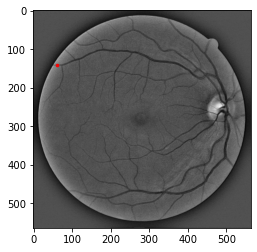

In [18]:
from imageio import imread
#from utils import perform_blurring, imageplot
import cv2
import numpy as np
import pylab
import matplotlib.pyplot as plt

img = cv2.cvtColor(cv2.imread('../../data/40_training.tif'), cv2.COLOR_BGR2RGB)

crop = img[584-564:584, 1:565]

gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

M = perform_blurring(gray,20)

f1 = M - gray

c = np.max(f1);
epsilon = 1e-2;
W = epsilon + np.abs(f1-c)
plt.imshow(W,cmap='gray')
plt.plot(60,140,'.r', markersize=5)
plt.show()
# Get brightness range - i.e. darkest and lightest pixels

